In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")
# Librerías comunes (ejecuta una vez)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.stattools import coint
from scipy.stats import zscore
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from arch import arch_model
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12,5)



Entrenando modelo SIMPLE para BBVA...
Epoch 1/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0013
Epoch 2/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5629e-04
Epoch 3/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.1188e-04
Epoch 4/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7538e-04
Epoch 5/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6165e-04
Epoch 6/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5050e-04
Epoch 7/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4273e-04
Epoch 8/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3688e-04
Epoch 9/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3205e-04
Epoch 10/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2780e-04
Epoch 11/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2405e-04
Epoch 12/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2085e-04
Epoch 13/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1817e-04
Epoch 14/40
181/181 ━━━━━━━━━━━━━━━━━━

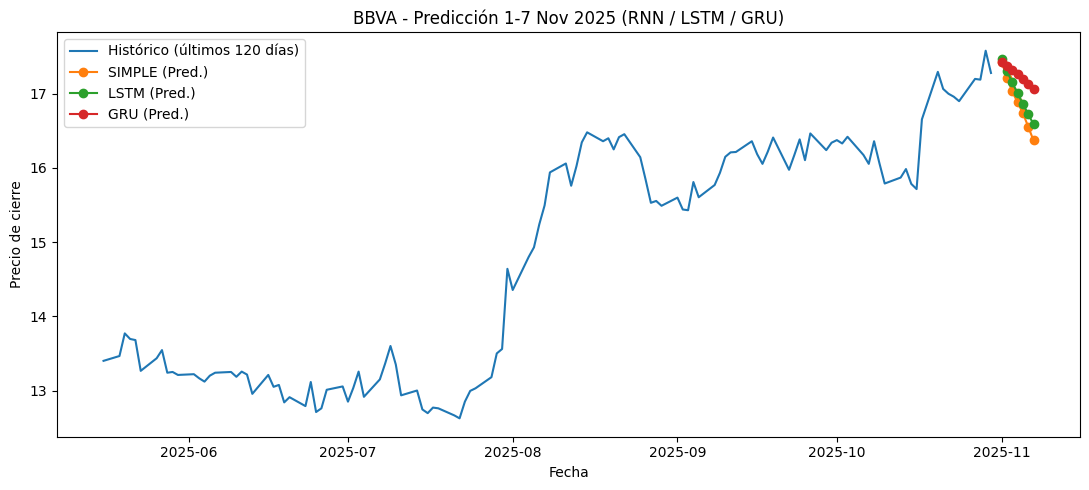

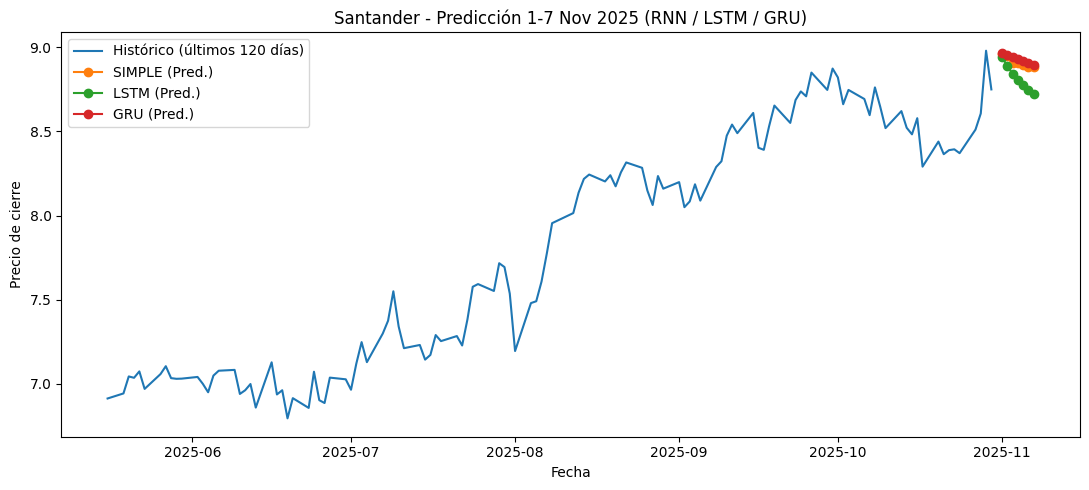


✅ Proceso completado correctamente.
Gráficas guardadas como:
  → bbva_predicciones_1-7nov2025.png
  → santander_predicciones_1-7nov2025.png


In [3]:
# prediccion_bancos_rnn.py
# ------------------------------------------------------------
# Requisitos:
#   pip install numpy pandas matplotlib scikit-learn tensorflow
# ------------------------------------------------------------

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping

# ---------------- CONFIGURACIÓN ----------------
LOOKBACK = 60       # días pasados usados como input
PRED_DAYS = 7       # predicciones del 1 al 7 de noviembre
EPOCHS = 40         # puedes subir a 80+ si tienes GPU
BATCH_SIZE = 32
UNITS = 64
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ------------------------------------------------------------
# FUNCIONES AUXILIARES
# ------------------------------------------------------------

def cargar_datos(archivo, columna_close):
    """
    Carga el CSV, ordena por fecha y devuelve DataFrame con columnas ['Date','Close']
    """
    df = pd.read_csv(archivo, parse_dates=['Date'])
    df = df.sort_values('Date').reset_index(drop=True)
    if columna_close not in df.columns:
        raise ValueError(f"No se encontró la columna {columna_close} en {archivo}")
    serie = df[['Date', columna_close]].copy()
    serie.columns = ['Date', 'Close']
    return serie

def preparar_datos(serie):
    """
    Escala la serie y genera secuencias para entrenamiento (LOOKBACK -> siguiente valor)
    """
    valores = serie['Close'].values.reshape(-1,1)
    scaler = MinMaxScaler()
    escalado = scaler.fit_transform(valores)
    X, y = [], []
    for i in range(LOOKBACK, len(escalado)):
        X.append(escalado[i-LOOKBACK:i, 0])
        y.append(escalado[i, 0])
    X = np.array(X).reshape(-1, LOOKBACK, 1)
    y = np.array(y)
    return X, y, scaler

def construir_modelo(tipo, input_shape):
    """
    Crea un modelo RNN simple, LSTM o GRU según 'tipo'
    """
    model = Sequential()
    if tipo == 'simple':
        model.add(SimpleRNN(UNITS, input_shape=input_shape))
    elif tipo == 'lstm':
        model.add(LSTM(UNITS, input_shape=input_shape))
    elif tipo == 'gru':
        model.add(GRU(UNITS, input_shape=input_shape))
    else:
        raise ValueError("tipo debe ser 'simple', 'lstm' o 'gru'")
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def entrenar_y_predecir(serie, nombre):
    """
    Entrena los tres modelos (SimpleRNN, LSTM, GRU) y predice 7 días
    """
    X, y, scaler = preparar_datos(serie)
    input_shape = (X.shape[1], X.shape[2])
    resultados = {}

    for tipo in ['simple', 'lstm', 'gru']:
        print(f"\nEntrenando modelo {tipo.upper()} para {nombre}...")
        model = construir_modelo(tipo, input_shape)
        es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=1)
        model.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=[es])

        # Predicción iterativa para los próximos 7 días
        ventana = X[-1].reshape(LOOKBACK)
        pred_scaled = []
        actual = ventana.copy()

        for _ in range(PRED_DAYS):
            inp = actual.reshape((1, LOOKBACK, 1))
            p = model.predict(inp, verbose=0)[0,0]
            pred_scaled.append(p)
            actual = np.roll(actual, -1)
            actual[-1] = p

        pred_scaled = np.array(pred_scaled).reshape(-1,1)
        pred = scaler.inverse_transform(pred_scaled).reshape(-1)
        resultados[tipo] = pred

    # Fechas de predicción: 1 al 7 de noviembre 2025
    fechas_pred = pd.date_range(start='2025-11-01', periods=PRED_DAYS, freq='D')
    return resultados, fechas_pred

def graficar_resultados(serie, resultados, fechas, titulo, archivo_salida):
    """
    Muestra y guarda gráfica comparando los tres modelos
    """
    plt.figure(figsize=(11,5))
    ultimos = serie.tail(120)
    plt.plot(ultimos['Date'], ultimos['Close'], label='Histórico (últimos 120 días)')
    for tipo, pred in resultados.items():
        plt.plot(fechas, pred, marker='o', label=f'{tipo.upper()} (Pred.)')
    plt.title(titulo)
    plt.xlabel('Fecha')
    plt.ylabel('Precio de cierre')
    plt.legend()
    plt.tight_layout()
    plt.savefig(archivo_salida)
    plt.show()

# ------------------------------------------------------------
# PROCESO PRINCIPAL
# ------------------------------------------------------------

if __name__ == "__main__":
    # Archivos esperados
    bbva_file = "bbva_completo.csv"
    san_file  = "santander_completo.csv"

    # Cargar datos
    bbva = cargar_datos(bbva_file, 'Close_BBVA.MC')
    san  = cargar_datos(san_file,  'Close_SAN.MC')

    # Entrenar y predecir
    preds_bbva, fechas_bbva = entrenar_y_predecir(bbva, 'BBVA')
    preds_san,  fechas_san  = entrenar_y_predecir(san,  'Santander')

    # Graficar resultados
    graficar_resultados(bbva, preds_bbva, fechas_bbva, 
                        "BBVA - Predicción 1-7 Nov 2025 (RNN / LSTM / GRU)",
                        "bbva_predicciones_1-7nov2025.png")

    graficar_resultados(san, preds_san, fechas_san,
                        "Santander - Predicción 1-7 Nov 2025 (RNN / LSTM / GRU)",
                        "santander_predicciones_1-7nov2025.png")

    print("\n✅ Proceso completado correctamente.")
    print("Gráficas guardadas como:")
    print("  → bbva_predicciones_1-7nov2025.png")
    print("  → santander_predicciones_1-7nov2025.png")


Cargando datos...
BBVA: (5852, 21) - Desde 2003-01-01 00:00:00 hasta 2025-10-30 00:00:00
Santander: (5852, 21) - Desde 2003-01-01 00:00:00 hasta 2025-10-30 00:00:00
Fechas a predecir: [Timestamp('2025-11-01 00:00:00'), Timestamp('2025-11-02 00:00:00'), Timestamp('2025-11-03 00:00:00'), Timestamp('2025-11-04 00:00:00'), Timestamp('2025-11-05 00:00:00'), Timestamp('2025-11-06 00:00:00'), Timestamp('2025-11-07 00:00:00')]

ENTRENANDO MODELOS PARA BBVA

Entrenando modelo SIMPLE...
Modelo SIMPLE entrenado - Loss: 0.0144

Entrenando modelo LSTM...
Modelo LSTM entrenado - Loss: 0.0075

Entrenando modelo GRU...
Modelo GRU entrenado - Loss: 0.0111

ENTRENANDO MODELOS PARA SANTANDER

Entrenando modelo SIMPLE...
Modelo SIMPLE entrenado - Loss: 0.0185

Entrenando modelo LSTM...
Modelo LSTM entrenado - Loss: 0.0062

Entrenando modelo GRU...
Modelo GRU entrenado - Loss: 0.0071

CREANDO GRÁFICAS PARA BBVA


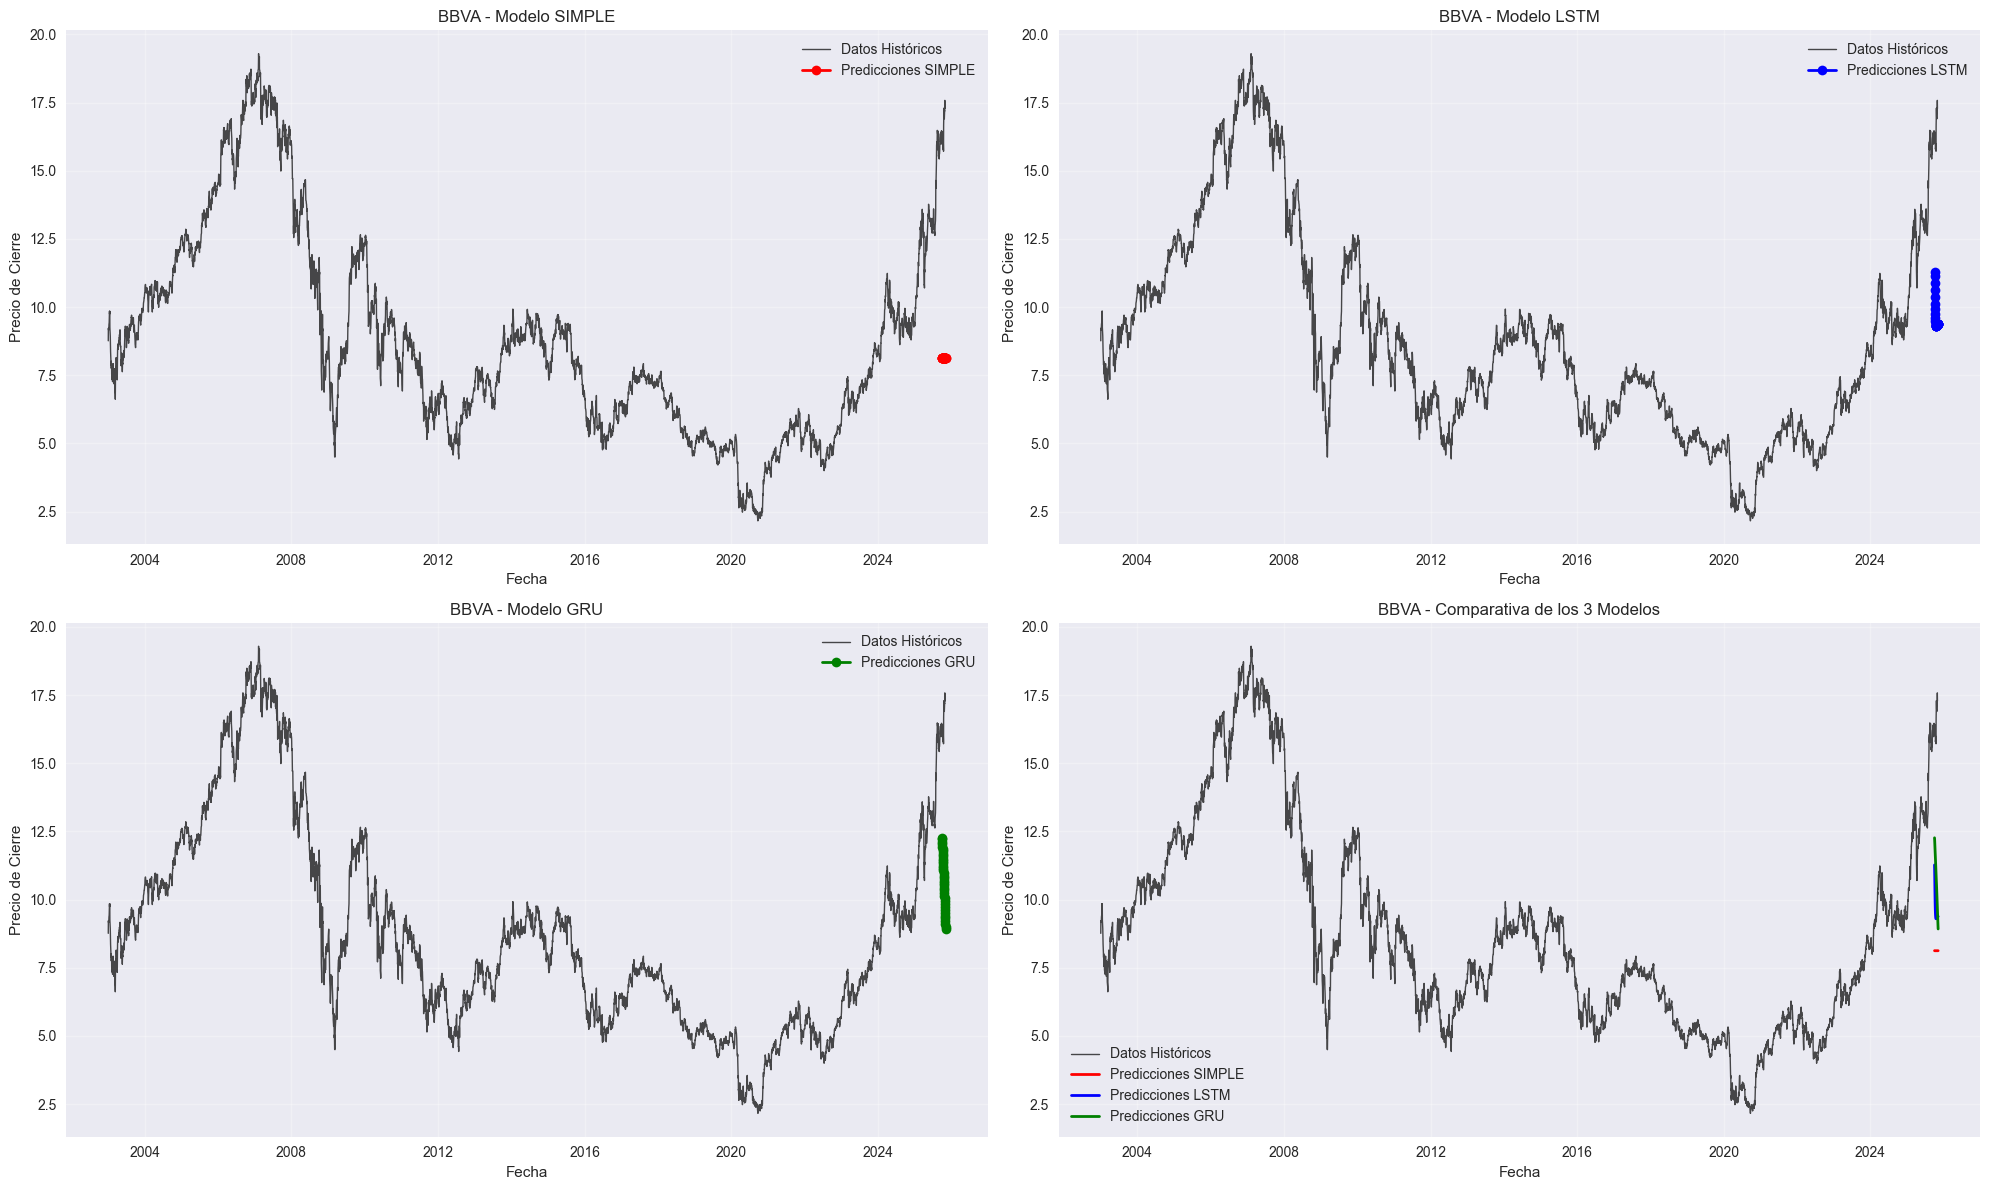

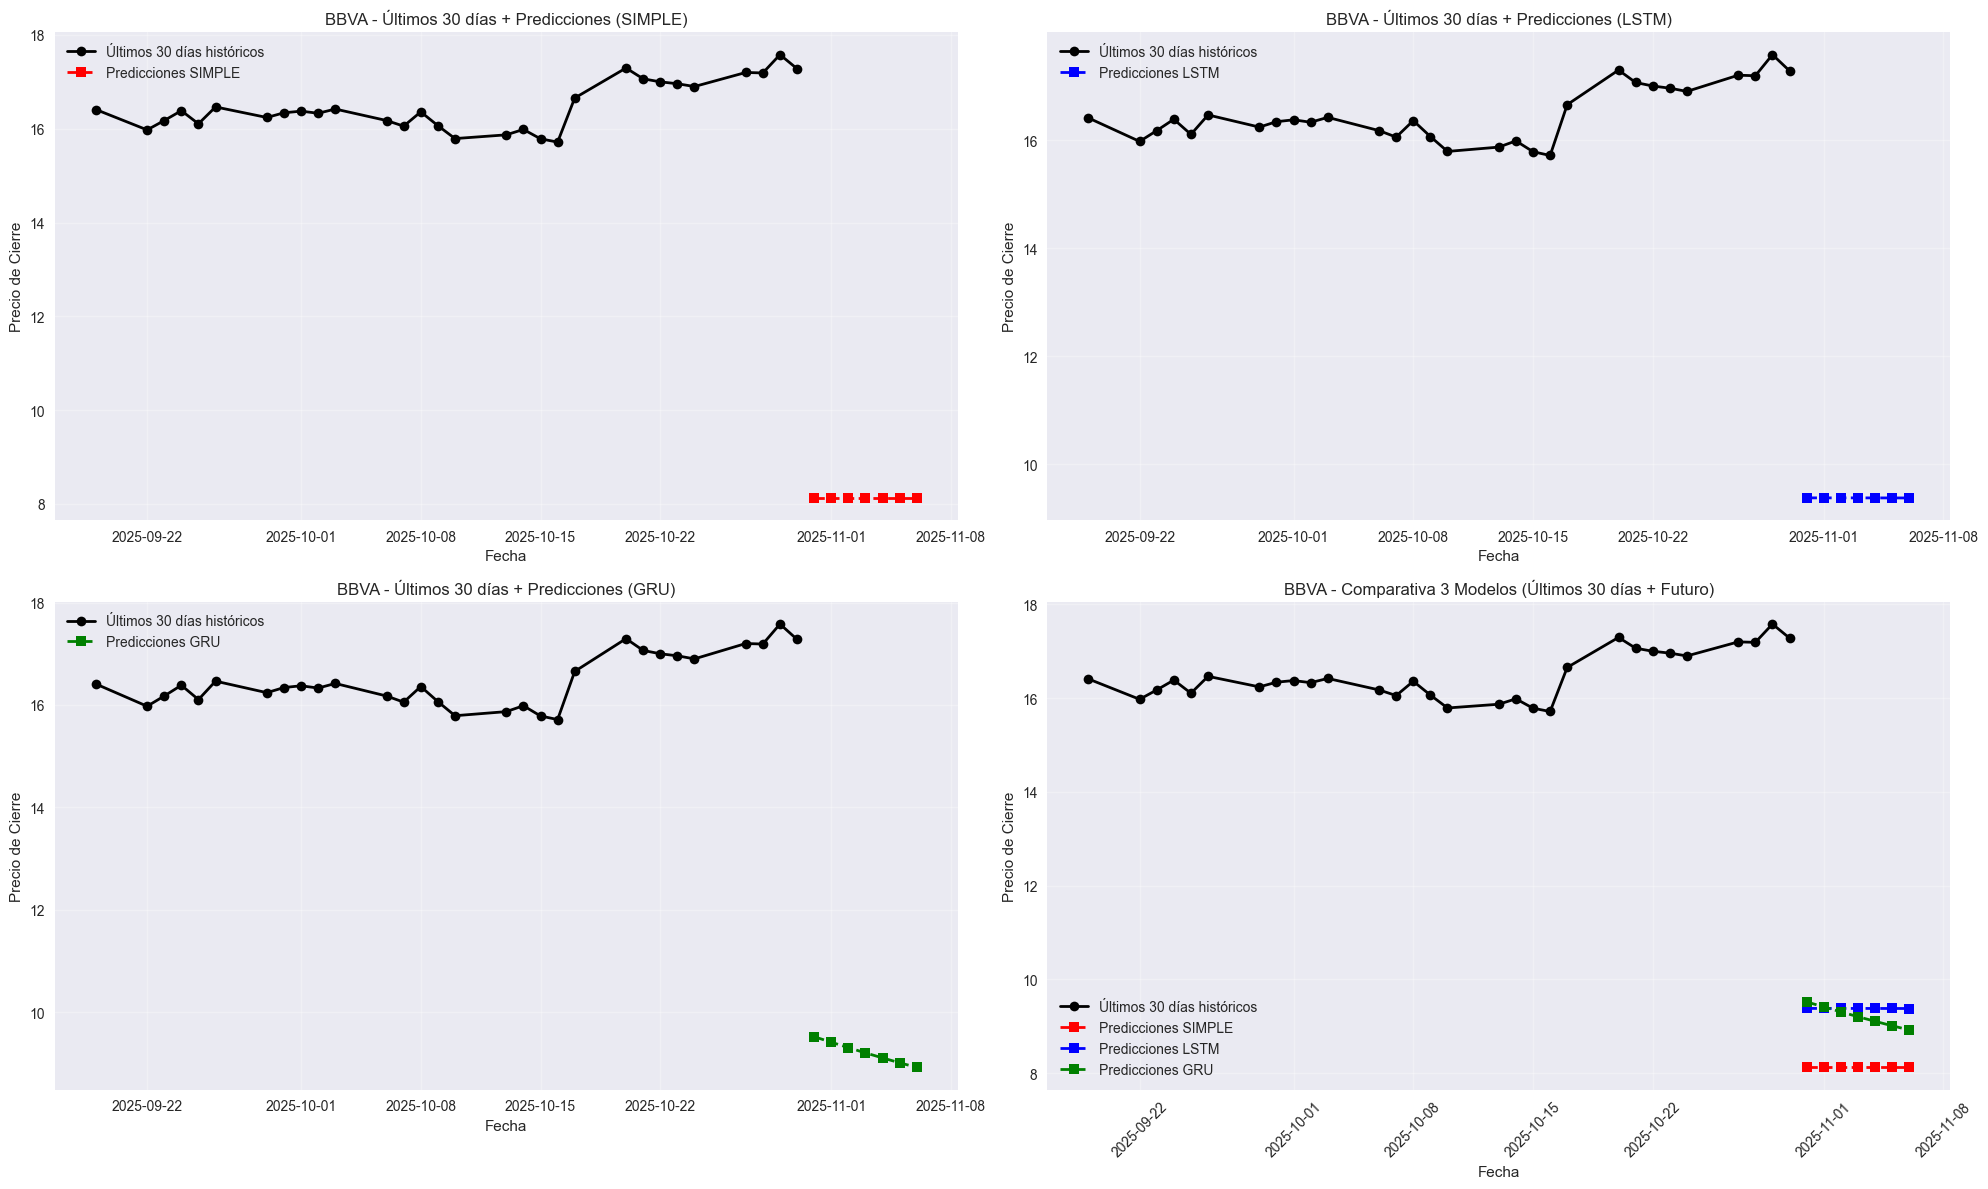


CREANDO GRÁFICAS PARA SANTANDER


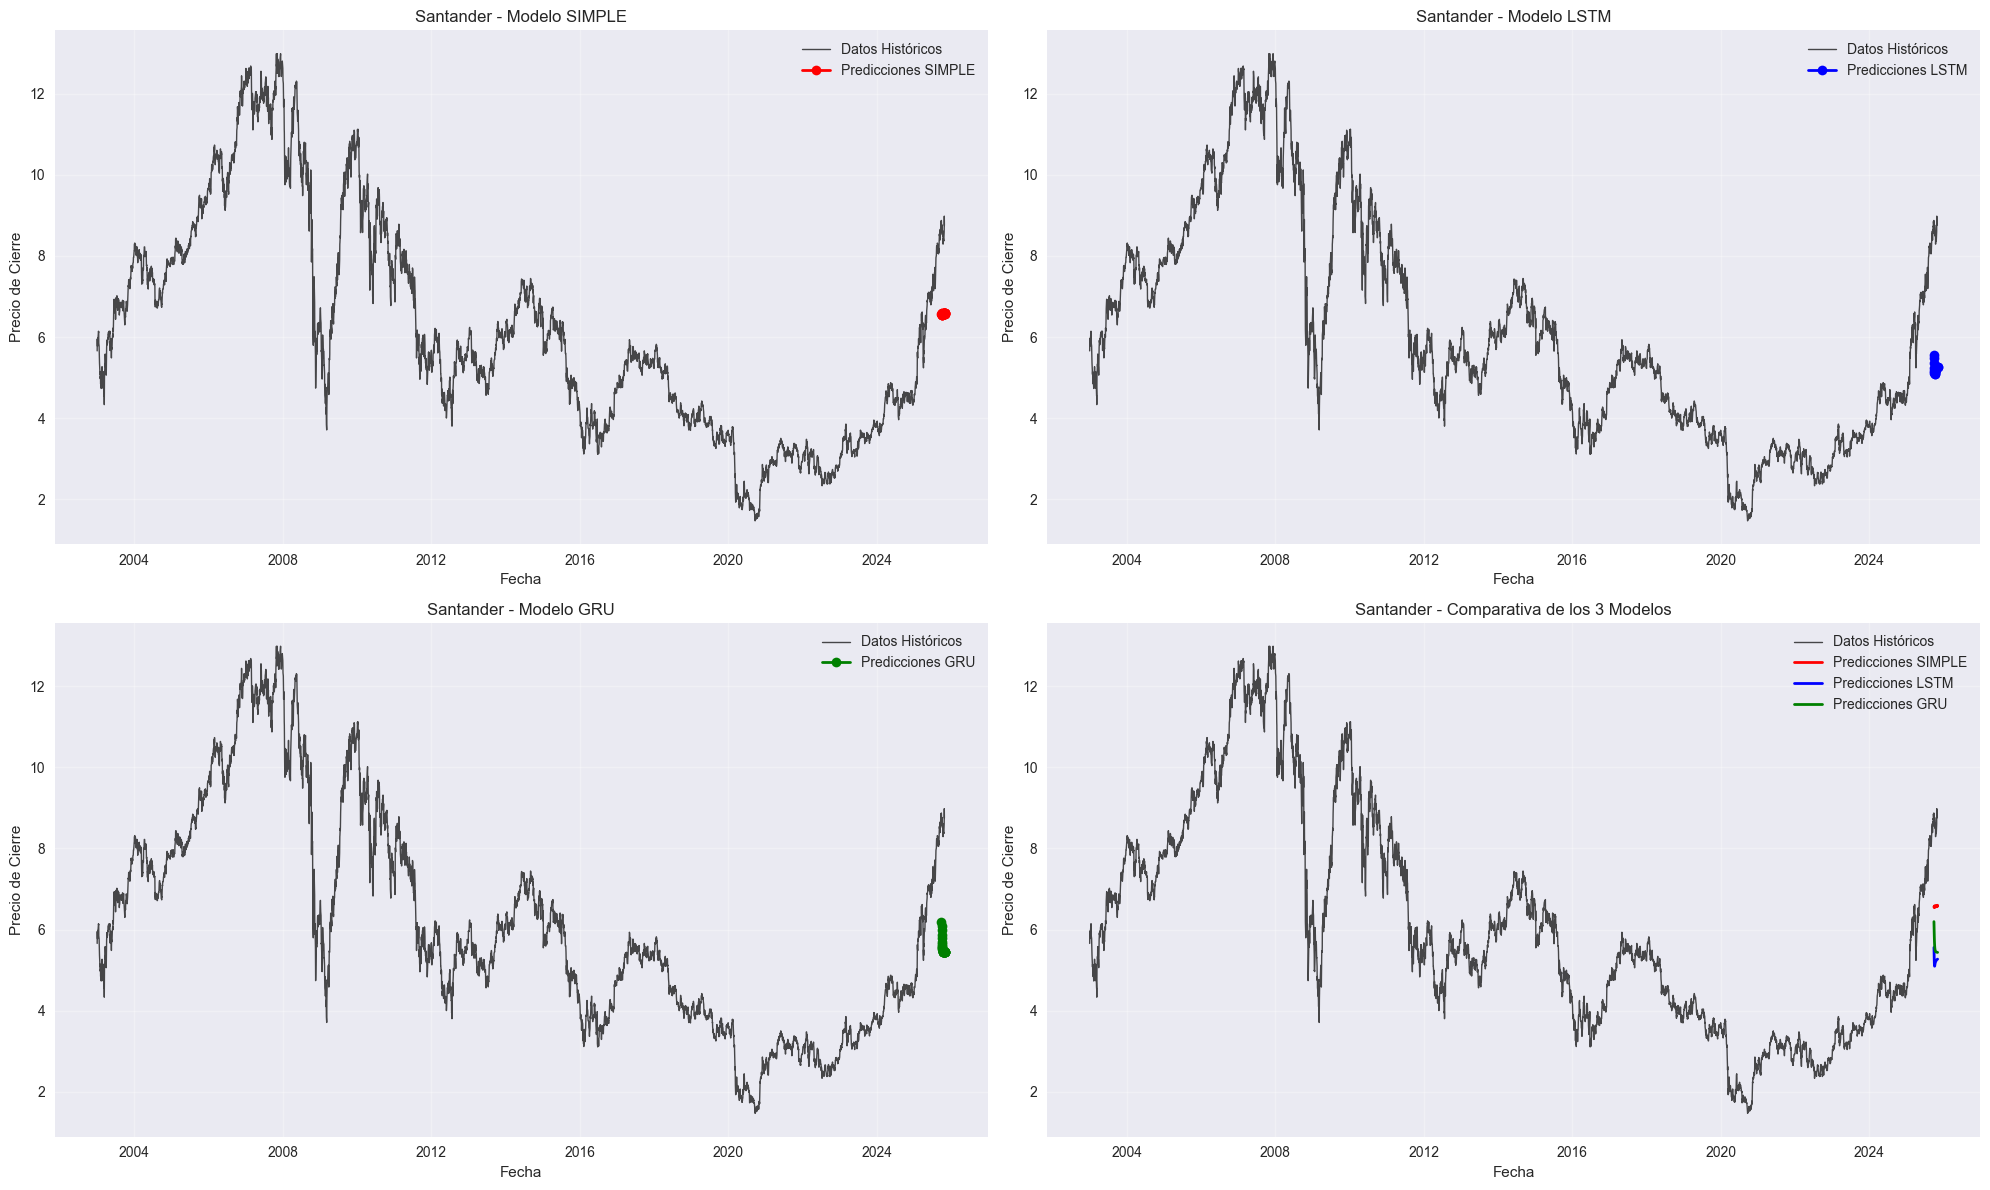

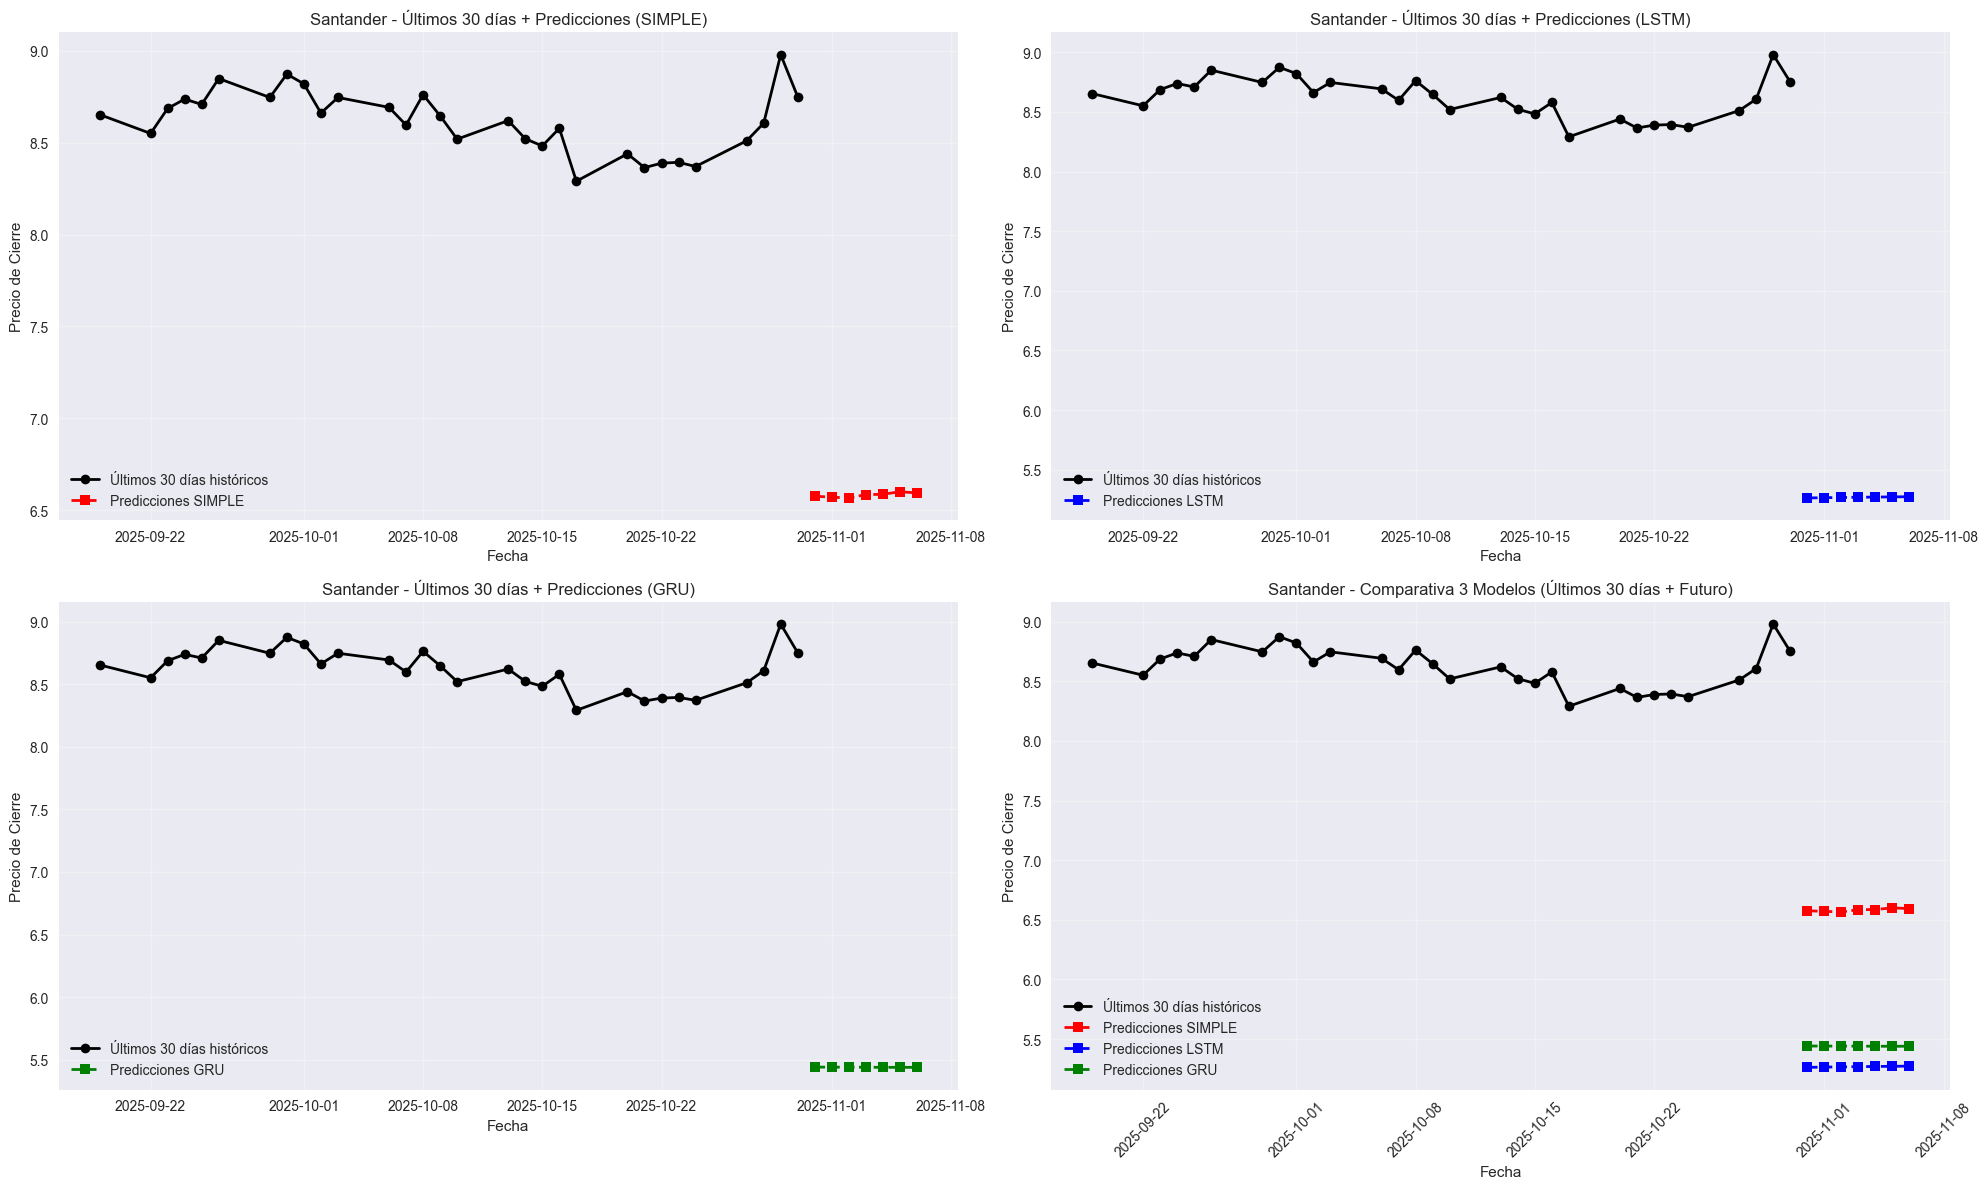


PREDICCIONES FINALES - NOVIEMBRE 2025

BBVA - Precios de Cierre Predichos:
--------------------------------------------------
2025-11-01:
  RNN Simple: 8.12 €
  LSTM:       9.38 €
  GRU:        9.52 €
2025-11-02:
  RNN Simple: 8.12 €
  LSTM:       9.38 €
  GRU:        9.41 €
2025-11-03:
  RNN Simple: 8.12 €
  LSTM:       9.38 €
  GRU:        9.31 €
2025-11-04:
  RNN Simple: 8.12 €
  LSTM:       9.38 €
  GRU:        9.21 €
2025-11-05:
  RNN Simple: 8.12 €
  LSTM:       9.38 €
  GRU:        9.11 €
2025-11-06:
  RNN Simple: 8.12 €
  LSTM:       9.38 €
  GRU:        9.01 €
2025-11-07:
  RNN Simple: 8.12 €
  LSTM:       9.38 €
  GRU:        8.92 €

Santander - Precios de Cierre Predichos:
--------------------------------------------------
2025-11-01:
  RNN Simple: 6.58 €
  LSTM:       5.26 €
  GRU:        5.44 €
2025-11-02:
  RNN Simple: 6.57 €
  LSTM:       5.26 €
  GRU:        5.44 €
2025-11-03:
  RNN Simple: 6.57 €
  LSTM:       5.27 €
  GRU:        5.44 €
2025-11-04:
  RNN Simple: 6.58

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Configuración
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Cargar datos
print("Cargando datos...")
bbva_df = pd.read_csv('bbva_completo.csv', parse_dates=['Date'])
santander_df = pd.read_csv('santander_completo.csv', parse_dates=['Date'])

# Ordenar por fecha
bbva_df = bbva_df.sort_values('Date')
santander_df = santander_df.sort_values('Date')

print(f"BBVA: {bbva_df.shape} - Desde {bbva_df['Date'].min()} hasta {bbva_df['Date'].max()}")
print(f"Santander: {santander_df.shape} - Desde {santander_df['Date'].min()} hasta {santander_df['Date'].max()}")

def prepare_data(df, target_column, lookback=60):
    """Prepara los datos para el modelo"""
    # Seleccionar características
    feature_columns = ['tasa_interes', 'inflacion', 'PIB', 'desempleo', 'tipo_cambio', 
                      'liquidez_M2', 'materias_primas', 'politica_monetaria', 
                      'sentimiento_global', 'inflacion_eurozona', 'desempleo_espana', 
                      "('VIX', '^VIX')"]
    
    features = df[feature_columns + [target_column]].copy()
    
    # Escalar datos
    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()
    
    features_scaled = scaler_features.fit_transform(features[feature_columns])
    target_scaled = scaler_target.fit_transform(features[[target_column]])
    
    # Crear secuencias
    X, y = [], []
    for i in range(lookback, len(features)):
        X.append(features_scaled[i-lookback:i])
        y.append(target_scaled[i, 0])
    
    return np.array(X), np.array(y), scaler_features, scaler_target

def create_rnn_model(input_shape, model_type='simple'):
    """Crea el modelo RNN según el tipo especificado"""
    model = Sequential()
    
    if model_type == 'simple':
        model.add(SimpleRNN(50, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.2))
        model.add(SimpleRNN(50, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(SimpleRNN(50))
        model.add(Dropout(0.2))
        
    elif model_type == 'lstm':
        model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.2))
        model.add(LSTM(50, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(50))
        model.add(Dropout(0.2))
        
    elif model_type == 'gru':
        model.add(GRU(50, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.2))
        model.add(GRU(50, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(GRU(50))
        model.add(Dropout(0.2))
    
    model.add(Dense(25))
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='mse', 
                  metrics=['mae'])
    
    return model

def train_and_predict(df, bank_name, target_column, lookback=60, future_days=7):
    """Entrena modelos y hace predicciones"""
    print(f"\n{'='*50}")
    print(f"ENTRENANDO MODELOS PARA {bank_name.upper()}")
    print(f"{'='*50}")
    
    # Preparar datos
    X, y, scaler_features, scaler_target = prepare_data(df, target_column, lookback)
    
    # Dividir datos (últimos 30 días para test + futuras predicciones)
    train_size = len(X) - 30 - future_days
    X_train, X_test = X[:train_size], X[train_size:train_size+30]
    y_train, y_test = y[:train_size], y[train_size:train_size+30]
    
    # Modelos a entrenar
    model_types = ['simple', 'lstm', 'gru']
    models = {}
    predictions = {}
    history_data = {}
    
    for model_type in model_types:
        print(f"\nEntrenando modelo {model_type.upper()}...")
        
        # Crear y entrenar modelo
        model = create_rnn_model((X_train.shape[1], X_train.shape[2]), model_type)
        
        history = model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=32,
            validation_data=(X_test, y_test),
            verbose=0,
            shuffle=False
        )
        
        models[model_type] = model
        history_data[model_type] = history
        
        # Predecir últimos 30 días + futuro
        last_sequence = X[-30:]  # Última secuencia disponible
        future_predictions = []
        
        current_sequence = last_sequence[-1:].copy()
        
        for _ in range(30 + future_days):
            pred = model.predict(current_sequence, verbose=0)[0, 0]
            future_predictions.append(pred)
            
            # Actualizar secuencia para siguiente predicción
            if _ < (30 + future_days - 1):
                # Crear nueva fila con características (usamos las últimas disponibles)
                new_row = current_sequence[0, -1, :].copy()
                new_row[-1] = pred  # Reemplazar el target con la predicción
                
                # Actualizar secuencia
                current_sequence = np.roll(current_sequence, -1, axis=1)
                current_sequence[0, -1, :] = new_row
        
        # Convertir predicciones a escala original
        future_predictions = np.array(future_predictions).reshape(-1, 1)
        predictions_scaled = np.zeros((len(future_predictions), len(scaler_features.get_feature_names_out()) + 1))
        predictions_scaled[:, -1] = future_predictions.flatten()
        
        predictions_original = scaler_target.inverse_transform(
            predictions_scaled[:, -1].reshape(-1, 1)
        )
        
        predictions[model_type] = predictions_original.flatten()
        
        print(f"Modelo {model_type.upper()} entrenado - Loss: {history.history['loss'][-1]:.4f}")
    
    return models, predictions, history_data, scaler_target

def create_plots(df, predictions, bank_name, target_column, future_dates):
    """Crea las gráficas comparativas"""
    
    # Fechas para las predicciones
    last_date = df['Date'].iloc[-1]
    prediction_dates = pd.date_range(start=last_date - pd.Timedelta(days=29), 
                                   periods=len(predictions['simple']), freq='D')
    
    historical_dates = df['Date']
    historical_prices = df[target_column]
    
    # 1. Gráfica completa histórica + predicciones
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()
    
    model_types = ['simple', 'lstm', 'gru']
    colors = ['red', 'blue', 'green']
    
    for idx, (model_type, color) in enumerate(zip(model_types, colors)):
        ax = axes[idx]
        
        # Datos históricos
        ax.plot(historical_dates, historical_prices, 
               label='Datos Históricos', color='black', alpha=0.7, linewidth=1)
        
        # Predicciones
        pred_start_idx = len(prediction_dates) - 37  # Últimos 30 días + 7 futuros
        ax.plot(prediction_dates[pred_start_idx:], 
               predictions[model_type][pred_start_idx:],
               label=f'Predicciones {model_type.upper()}', 
               color=color, linewidth=2, marker='o')
        
        ax.set_title(f'{bank_name} - Modelo {model_type.upper()}')
        ax.set_xlabel('Fecha')
        ax.set_ylabel('Precio de Cierre')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Gráfica comparativa de los 3 modelos
    ax = axes[3]
    ax.plot(historical_dates, historical_prices, 
           label='Datos Históricos', color='black', alpha=0.7, linewidth=1)
    
    for model_type, color in zip(model_types, colors):
        pred_start_idx = len(prediction_dates) - 37
        ax.plot(prediction_dates[pred_start_idx:], 
               predictions[model_type][pred_start_idx:],
               label=f'Predicciones {model_type.upper()}', 
               color=color, linewidth=2)
    
    ax.set_title(f'{bank_name} - Comparativa de los 3 Modelos')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Precio de Cierre')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Gráfica de últimos 30 días + predicciones futuras
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()
    
    # Últimos 30 días históricos
    last_30_dates = historical_dates[-30:]
    last_30_prices = historical_prices[-30:]
    
    for idx, (model_type, color) in enumerate(zip(model_types, colors)):
        ax = axes[idx]
        
        # Últimos 30 días históricos
        ax.plot(last_30_dates, last_30_prices, 
               label='Últimos 30 días históricos', color='black', linewidth=2, marker='o')
        
        # Predicciones (30 días de validación + 7 días futuros)
        future_part = predictions[model_type][30:]  # Los últimos 7 días son predicciones futuras
        future_dates_plot = prediction_dates[30:]
        
        ax.plot(future_dates_plot, future_part,
               label=f'Predicciones {model_type.upper()}', 
               color=color, linewidth=2, marker='s', linestyle='--')
        
        ax.set_title(f'{bank_name} - Últimos 30 días + Predicciones ({model_type.upper()})')
        ax.set_xlabel('Fecha')
        ax.set_ylabel('Precio de Cierre')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
    
    # Gráfica comparativa de los 3 modelos (últimos 30 días)
    ax = axes[3]
    ax.plot(last_30_dates, last_30_prices, 
           label='Últimos 30 días históricos', color='black', linewidth=2, marker='o')
    
    for model_type, color in zip(model_types, colors):
        future_part = predictions[model_type][30:]
        future_dates_plot = prediction_dates[30:]
        
        ax.plot(future_dates_plot, future_part,
               label=f'Predicciones {model_type.upper()}', 
               color=color, linewidth=2, marker='s', linestyle='--')
    
    ax.set_title(f'{bank_name} - Comparativa 3 Modelos (Últimos 30 días + Futuro)')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Precio de Cierre')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Fechas objetivo para predicción
future_dates = pd.date_range(start='2025-11-01', end='2025-11-07', freq='D')
print(f"Fechas a predecir: {future_dates.tolist()}")

# Entrenar para BBVA
bbva_models, bbva_predictions, bbva_history, bbva_scaler = train_and_predict(
    bbva_df, 'BBVA', 'Close_BBVA.MC'
)

# Entrenar para Santander
santander_models, santander_predictions, santander_history, santander_scaler = train_and_predict(
    santander_df, 'Santander', 'Close_SAN.MC'
)

# Crear gráficas para BBVA
print(f"\n{'='*50}")
print("CREANDO GRÁFICAS PARA BBVA")
print(f"{'='*50}")
create_plots(bbva_df, bbva_predictions, 'BBVA', 'Close_BBVA.MC', future_dates)

# Crear gráficas para Santander
print(f"\n{'='*50}")
print("CREANDO GRÁFICAS PARA SANTANDER")
print(f"{'='*50}")
create_plots(santander_df, santander_predictions, 'Santander', 'Close_SAN.MC', future_dates)

# Mostrar predicciones finales
print(f"\n{'='*80}")
print("PREDICCIONES FINALES - NOVIEMBRE 2025")
print(f"{'='*80}")

print(f"\nBBVA - Precios de Cierre Predichos:")
print("-" * 50)
for i, date in enumerate(future_dates):
    print(f"{date.strftime('%Y-%m-%d')}:")
    print(f"  RNN Simple: {bbva_predictions['simple'][30+i]:.2f} €")
    print(f"  LSTM:       {bbva_predictions['lstm'][30+i]:.2f} €")
    print(f"  GRU:        {bbva_predictions['gru'][30+i]:.2f} €")

print(f"\nSantander - Precios de Cierre Predichos:")
print("-" * 50)
for i, date in enumerate(future_dates):
    print(f"{date.strftime('%Y-%m-%d')}:")
    print(f"  RNN Simple: {santander_predictions['simple'][30+i]:.2f} €")
    print(f"  LSTM:       {santander_predictions['lstm'][30+i]:.2f} €")
    print(f"  GRU:        {santander_predictions['gru'][30+i]:.2f} €")

# Resumen estadístico
print(f"\n{'='*80}")
print("RESUMEN ESTADÍSTICO")
print(f"{'='*80}")

def print_statistics(predictions, bank_name):
    print(f"\n{bank_name}:")
    for model_type in ['simple', 'lstm', 'gru']:
        preds = predictions[model_type][30:37]  # Solo las predicciones futuras
        print(f"  {model_type.upper():8} - Media: {np.mean(preds):.2f} €, "
              f"Std: {np.std(preds):.2f} €, "
              f"Rango: {np.min(preds):.2f}-{np.max(preds):.2f} €")

print_statistics(bbva_predictions, "BBVA")
print_statistics(santander_predictions, "Santander")